In [1]:
import os
import kagglehub
import numpy as np
from tqdm import tqdm
from PIL import Image
import shutil
import cv2

import random
import matplotlib.pyplot as plt

import hashlib


/Users/porter/ASU/DAT490/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download the dataset
dataset_7_path = kagglehub.dataset_download("denizkavi1/brain-tumor")

print("Dataset downloaded:", {dataset_7_path})

100%|██████████| 700M/700M [00:26<00:00, 27.5MB/s] 

Extracting files...


Dataset downloaded: {'/Users/porter/.cache/kagglehub/datasets/denizkavi1/brain-tumor/versions/2'}


In [4]:
dataset_7_path = r'/Users/porter/.cache/kagglehub/datasets/denizkavi1/brain-tumor/versions/2'
output_folder = r"./Processed_BrainTumor"

# Changing the folders [1, 2, 3] to decided labels and adding no_tumor
label_mapping = {
    "1": "Meningioma",
    "2": "Glioma",
    "3": "Pituitary",
    "0": "No_Tumor" 
}

for label, tumor_name in label_mapping.items():
    os.makedirs(os.path.join(output_folder, tumor_name), exist_ok=True)

for label, tumor_name in label_mapping.items():
    old_folder = os.path.join(dataset_7_path, label)
    new_folder = os.path.join(output_folder, tumor_name)

    if os.path.exists(old_folder):
        for img_name in os.listdir(old_folder):
            old_path = os.path.join(old_folder, img_name)
            new_path = os.path.join(new_folder, img_name)

            shutil.move(old_path, new_path)
    else:
        print(f"Folder {old_folder} does not exist")

no_tumor_folder = os.path.join(output_folder, "No_Tumor")
if not os.path.exists(no_tumor_folder) or not os.listdir(no_tumor_folder):
    print("No 'No_Tumor' images, an empty folder has been made")


Folder /Users/porter/.cache/kagglehub/datasets/denizkavi1/brain-tumor/versions/2/0 does not exist
No 'No_Tumor' images, an empty folder has been made


In [5]:
# Checking if the new folders are correct
print("Folders:", os.listdir(output_folder))

Folders: ['Pituitary', 'No_Tumor', 'Glioma', 'Meningioma']


In [7]:
processed_dataset7_path = r"./Processed_BrainTumor"
output_folder = r"./Final_Preprocessed_BrainTumor"

categories = ['Glioma', 'Meningioma', 'No_Tumor', 'Pituitary']
for category in categories:
    os.makedirs(os.path.join(output_folder, category), exist_ok=True)

image_size = (250, 250) 

def preprocess_images():
    for category in categories:
        input_folder = os.path.join(processed_dataset7_path, category)  
        output_category_folder = os.path.join(output_folder, category)

        if not os.path.exists(input_folder):
            print(f"Warning: {input_folder} not found")
            continue

        for img_name in tqdm(os.listdir(input_folder)):
            img_path = os.path.join(input_folder, img_name)
            
            try:
                img = cv2.imread(img_path)
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_resized = cv2.resize(img_gray, image_size)

                output_img_name = os.path.splitext(img_name)[0] + ".jpg"
                output_path = os.path.join(output_category_folder, output_img_name)

                cv2.imwrite(output_path, img_resized)

            except Exception as e:
                print(f"Error processing {img_name}: {e}")

preprocess_images()

100%|██████████| 708/708 [00:03<00:00, 187.57it/s]
0it [00:00, ?it/s]
100%|██████████| 930/930 [00:05<00:00, 173.48it/s]


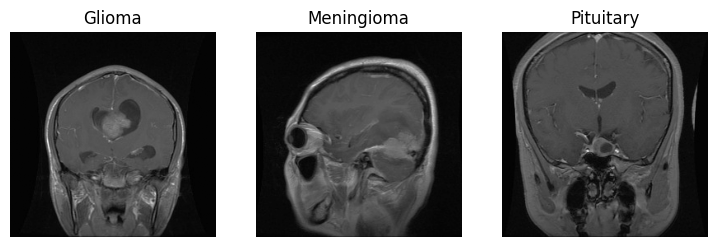

In [8]:
# Plot one random image from each folder except no_tumor
categories = ['Glioma', 'Meningioma', 'Pituitary']

plt.figure(figsize=(9, 6))
for i, category in enumerate(categories):
    folder_path = os.path.join(output_folder, category)
    img_name = random.choice(os.listdir(folder_path)) 
    img = cv2.imread(os.path.join(folder_path, img_name), cv2.IMREAD_GRAYSCALE)

    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(category)
    plt.axis("off")

plt.show()

## EDA of Dataset 7

In [9]:
# Total images in each category and total of images
class_counts = {}
for category in os.listdir(output_folder):
    category_path = os.path.join(output_folder, category)
    if os.path.isdir(category_path):
        num = len(os.listdir(category_path))
        class_counts[category] = num

for category, count in class_counts.items():
    print(f"{category}: {count} images")

total_images = sum(class_counts.values())
print(f" Total images: {total_images}")

Pituitary: 930 images
No_Tumor: 0 images
Glioma: 1426 images
Meningioma: 708 images
 Total images: 3064


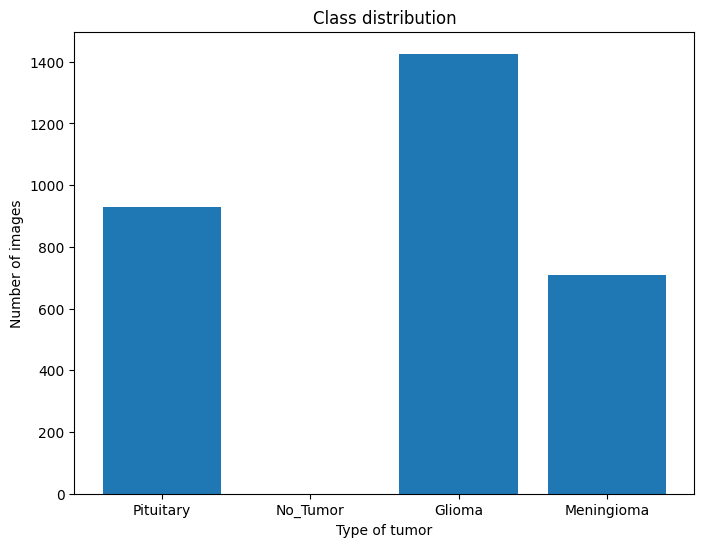

In [10]:
# Plot of class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Type of tumor")
plt.ylabel("Number of images")
plt.title("Class distribution")
plt.show()

In [ ]:
# Check for duplicates
image_hashes = {}
duplicates = []
for category in os.listdir(output_folder):
    folder_path = os.path.join(output_folder, category)

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        try:
            with open(image_path, "rb") as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            if file_hash in image_hashes:
                duplicates.append((image_path, image_hashes[file_hash]))
                print(f"There are duplicates: {image_name}")

            else:
                image_hashes[file_hash] = image_path
        except Exception as e:
            print(f"Error processing {image_name}: {e}")

if duplicates:
    print("Duplicate images found")
else:
    print("No duplicate images")

No duplicate images


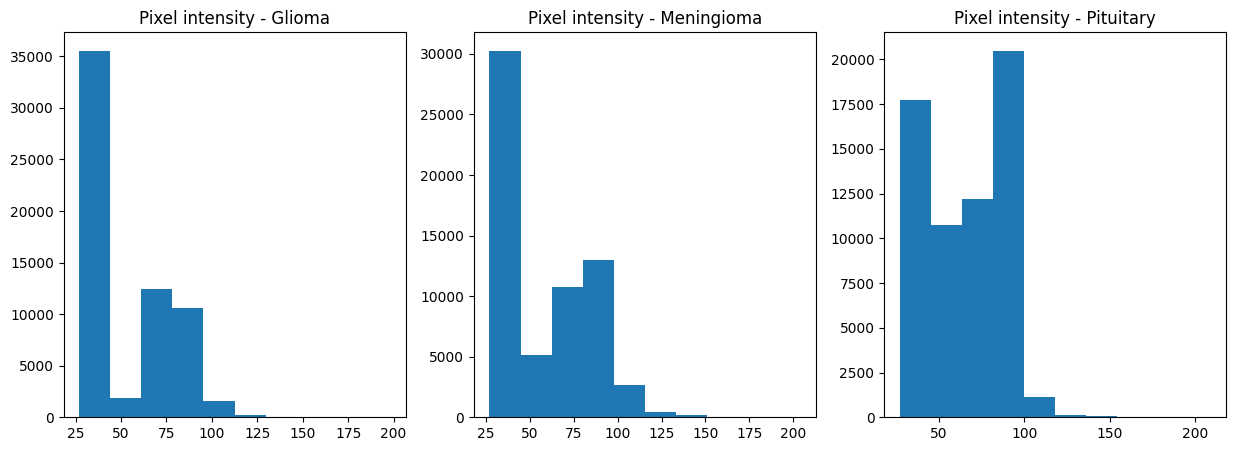

In [12]:
# Pixel distribution
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))

for i, category in enumerate(categories):
    folder_path = os.path.join(output_folder, category)
    image_files = os.listdir(folder_path)
    image_name = random.choice(image_files)
    image_path = os.path.join(folder_path, image_name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    axes[i].hist(image.ravel(), bins=10)
    axes[i].set_title(f"Pixel intensity - {category}")

plt.show()